## Dependencies

In [1]:
%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

C:\Users\Abhijit\Documents\GitHub\cpsc490\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [2]:
dataset = Planetoid(root='../data/Cora', name='Cora')

data = dataset[0]

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:data.num_nodes - 1000] = 1

data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask[data.num_nodes - 1000:data.num_nodes - 500] = 1

data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[data.num_nodes - 500:] = 1

## Model

In [3]:
class Net(torch.nn.Module):
    def __init__(self, num_features, dim=16, num_classes=1):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, dim)
        self.conv2 = GCNConv(dim, num_classes)

    def forward(self, x, edge_index, data=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## Training

In [4]:
epochs = 200
dim = 16

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=dataset.num_features, dim=dim, num_classes=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

In [6]:
def test(model, data):
    model.eval()
    logits, accs = model(data.x, data.edge_index, data), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [7]:
train_acc, val_acc, test_acc = 0, 0, 0
data = data.to(device)

for epoch in range(epochs):
    model.train()
    loss = 0
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index, data)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # validate
    train_acc, val_acc, test_acc = test(model, data)
    train_loss = loss
    
    print('Train_loss:{:.6f} Train_acc: {:.4f}, Val_acc: {:.4f}, Test_acc: {:.4f}'.format(loss, train_acc, val_acc, test_acc))

Train_loss:1.944373 Train_acc: 0.3337, Val_acc: 0.3280, Test_acc: 0.3620
Train_loss:1.844523 Train_acc: 0.3249, Val_acc: 0.3220, Test_acc: 0.3560
Train_loss:1.748508 Train_acc: 0.3460, Val_acc: 0.3240, Test_acc: 0.3900
Train_loss:1.649350 Train_acc: 0.4104, Val_acc: 0.3560, Test_acc: 0.4560
Train_loss:1.556338 Train_acc: 0.5240, Val_acc: 0.4260, Test_acc: 0.5560
Train_loss:1.458292 Train_acc: 0.6136, Val_acc: 0.5260, Test_acc: 0.6500
Train_loss:1.374628 Train_acc: 0.6827, Val_acc: 0.5960, Test_acc: 0.7100
Train_loss:1.300629 Train_acc: 0.7207, Val_acc: 0.6280, Test_acc: 0.7560
Train_loss:1.227903 Train_acc: 0.7564, Val_acc: 0.6760, Test_acc: 0.7780
Train_loss:1.145078 Train_acc: 0.7951, Val_acc: 0.7200, Test_acc: 0.8080
Train_loss:1.081926 Train_acc: 0.8208, Val_acc: 0.7480, Test_acc: 0.8140
Train_loss:1.019737 Train_acc: 0.8443, Val_acc: 0.7700, Test_acc: 0.8240
Train_loss:0.961286 Train_acc: 0.8618, Val_acc: 0.8000, Test_acc: 0.8400
Train_loss:0.920576 Train_acc: 0.8782, Val_acc: 0.8

Train_loss:0.345952 Train_acc: 0.9479, Val_acc: 0.8620, Test_acc: 0.8980
Train_loss:0.343593 Train_acc: 0.9456, Val_acc: 0.8640, Test_acc: 0.8980
Train_loss:0.336662 Train_acc: 0.9438, Val_acc: 0.8660, Test_acc: 0.8980
Train_loss:0.345788 Train_acc: 0.9397, Val_acc: 0.8640, Test_acc: 0.8920
Train_loss:0.347935 Train_acc: 0.9385, Val_acc: 0.8760, Test_acc: 0.8920
Train_loss:0.355053 Train_acc: 0.9438, Val_acc: 0.8720, Test_acc: 0.8960
Train_loss:0.357844 Train_acc: 0.9467, Val_acc: 0.8600, Test_acc: 0.8980
Train_loss:0.340296 Train_acc: 0.9479, Val_acc: 0.8620, Test_acc: 0.9000
Train_loss:0.337270 Train_acc: 0.9491, Val_acc: 0.8640, Test_acc: 0.9040
Train_loss:0.334345 Train_acc: 0.9450, Val_acc: 0.8660, Test_acc: 0.9020
Train_loss:0.356387 Train_acc: 0.9473, Val_acc: 0.8700, Test_acc: 0.8980
Train_loss:0.338184 Train_acc: 0.9450, Val_acc: 0.8720, Test_acc: 0.8980
Train_loss:0.326741 Train_acc: 0.9461, Val_acc: 0.8700, Test_acc: 0.8940
Train_loss:0.330733 Train_acc: 0.9479, Val_acc: 0.8

## GNNExplainer

In [8]:
node_idx = 17
x, edge_index = data.x, data.edge_index
explainer = GNNExplainer(model, epochs=200)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

Explain node 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 262.13it/s]


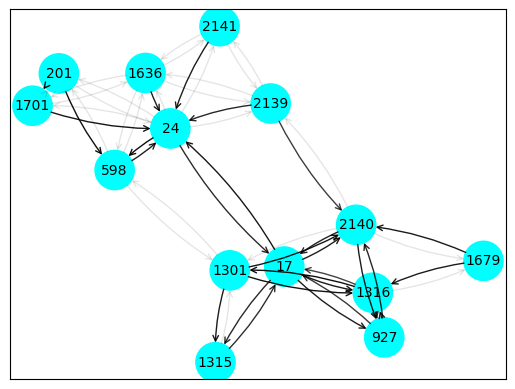

In [9]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()